In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

import nltk
from nltk import pos_tag
from nltk.util import ngrams
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

from nltk.probability import FreqDist

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/raychannudam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/raychannudam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/raychannudam/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/raychannudam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
translator = str.maketrans("","",string.punctuation)
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
STOP_WORDS = stopwords.words('english')
VOCAB_SIZE = 1000

In [3]:
# read negative and positive reviews
with open('negative-reviews.txt') as file:
    negative_content = file.readlines()
    file.close()
with open('positive-reviews.txt') as file:
    positive_content = file.readlines()
    file.close()

In [4]:
# read negative and positive words
with open('negative-words.txt', encoding='latin-1') as file:
    negative_words = file.readlines()
    file.close()
with open('positive-words.txt') as file:
    positive_words = file.readlines()
    file.close()

In [5]:
# create removeNewline function
def removeNewline(content):
    return re.sub("\n", "", content)

# convert to lowercase
def toLower(content):
    return content.lower()

# remove punctuation
def removePunctuation(content):
    return content.translate(translator)

# word lemmatization
def wordLemmatization(content):
    words = nltk.word_tokenize(content)
    tagged_words = pos_tag(words)
    lemma = [lemmatizer.lemmatize(word, "v") if pos in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'] else word for word, pos in tagged_words]
    return " ".join(lemma)

# remove single character
def removeSingleChar(content):
    return re.sub(r'\b\w{1}\b', '', content)

# remove pronounce
def removePronouns(content):
    words = nltk.word_tokenize(content)
    tagged_words = pos_tag(words)
    non_pronounces = [word for word, pos in tagged_words if pos not in ['PRP', 'PRP$', 'WP', 'WP$']]
    return " ".join(non_pronounces)

# remove stopwords
def removeStopwords(content):
  words = []
  words = content.split(" ")
  all_words = set(words)
  common_words = set(words).intersection(set(STOP_WORDS))
  uncommon_words = list(all_words - common_words)
  return " ".join(uncommon_words)

# remove common
def removeCommon(content, common_words):
  words = set(content.split(" "))
  common_words = set(common_words)
  found_common_words = list(common_words.intersection(words))
  uncommon_words = [word for word in content.split(" ") if word not in found_common_words]
  return " ".join(uncommon_words)


In [6]:
def preprocessing(content):
    content = removeNewline(content)
    content = toLower(content)
    content = removePunctuation(content)
    content = wordLemmatization(content)
    content = removePronouns(content)
    # content = removeStopwords(content)
    return content

In [7]:
temps = []
contents = [negative_content, positive_content, negative_words, positive_words]
for content in contents:
    temp = [preprocessing(sentence) for sentence in content]
    temps.append(temp)
cleaned_negative_content = temps[0]
cleaned_positive_content = temps[1]
cleaned_negative_words = temps[2]
cleaned_positive_words = temps[3]

In [8]:
temps = []
contents = [negative_content, positive_content, negative_words, positive_words]
for content in contents:
    temp = [removeNewline(sentence) for sentence in content]
    temps.append(temp)

temps = []
for content in contents:
    temp = [toLower(sentence) for sentence in content]
    temps.append(temp)
negative_content = temps[0]
positive_content = temps[1]
negative_words = temps[2]
positive_words = temps[3]

In [9]:
# checking common_words and unique vocab

tokens = []
contents = [cleaned_negative_content, cleaned_positive_content, cleaned_negative_words, cleaned_positive_words]
for content in contents:
    temp = [nltk.word_tokenize(sentence) for sentence in content]
    tokens.append(temp)
flat_unigrams = [ t for token_list in tokens for token in token_list for t in token]
fdist_unigrams = FreqDist(token for token in flat_unigrams)
common_words = [word for word in list(set([item[0] for item in fdist_unigrams.most_common(50)]).intersection(STOP_WORDS)) if word != "no" and word != "not" and word != "but"]
print(f"Common words: {common_words}")
print(f"Total number of unique_words = {fdist_unigrams.B()}")

Common words: ['have', 'with', 'very', 'a', 'the', 'on', 'too', 'can', 'and', 'in', 'to', 'of', 'be', 'for']
Total number of unique_words = 16538


In [10]:
with open("common_word.txt", "w") as f:
    for word in common_words:
        f.write(f"{word}\n")
    f.close()

In [11]:
# remove top 50 common words, where are in STOP_WORDS list

temps = []
contents = [cleaned_negative_content, cleaned_positive_content, cleaned_negative_words, cleaned_positive_words]
for content in contents:
    temp = [removeCommon(sentence, common_words) for sentence in content]
    temps.append(temp)
cleaned_negative_content = temps[0]
cleaned_positive_content = temps[1]
cleaned_negative_words = temps[2]
cleaned_positive_words = temps[3]

In [12]:
positive_df = pd.DataFrame({
    "review": positive_content,
    "cleaned_review": cleaned_positive_content,
    "category": 1
})
negative_df = pd.DataFrame({
    "review": negative_content,
    "cleaned_review": cleaned_negative_content,
    "category": 0
})
df = pd.concat([positive_df, negative_df], ignore_index=True)
df.head()

,review,cleaned_review,category
0,"size, size, ans size.\n",size size ans size,1
1,"excellent quality, speedy printing, low cost\n",excellent quality speedy print low cost,1
2,"cheap, good quality, small size\n",cheap good quality small size,1
3,"attractive design, satisfying features, the ba...",attractive design satisfying feature backlight,1
4,pretty much has every feature you could possib...,pretty much every feature could possibly need ...,1


In [13]:
df['pos_count'] = df['review'].apply(lambda x: len([word for word in x.split() if word in positive_words]))
df.head()

,review,cleaned_review,category,pos_count
0,"size, size, ans size.\n",size size ans size,1,0
1,"excellent quality, speedy printing, low cost\n",excellent quality speedy print low cost,1,0
2,"cheap, good quality, small size\n",cheap good quality small size,1,0
3,"attractive design, satisfying features, the ba...",attractive design satisfying feature backlight,1,0
4,pretty much has every feature you could possib...,pretty much every feature could possibly need ...,1,0


In [14]:
df['neg_count'] = df['review'].apply(lambda x: len([word for word in x.split() if word in negative_words]))
df.head()

,review,cleaned_review,category,pos_count,neg_count
0,"size, size, ans size.\n",size size ans size,1,0,0
1,"excellent quality, speedy printing, low cost\n",excellent quality speedy print low cost,1,0,0
2,"cheap, good quality, small size\n",cheap good quality small size,1,0,0
3,"attractive design, satisfying features, the ba...",attractive design satisfying feature backlight,1,0,0
4,pretty much has every feature you could possib...,pretty much every feature could possibly need ...,1,0,0


In [15]:
df['contain_no'] = df['review'].apply(lambda x: 1 if 'no' in x.split() else 0)
df.head()

,review,cleaned_review,category,pos_count,neg_count,contain_no
0,"size, size, ans size.\n",size size ans size,1,0,0,0
1,"excellent quality, speedy printing, low cost\n",excellent quality speedy print low cost,1,0,0,0
2,"cheap, good quality, small size\n",cheap good quality small size,1,0,0,0
3,"attractive design, satisfying features, the ba...",attractive design satisfying feature backlight,1,0,0,0
4,pretty much has every feature you could possib...,pretty much every feature could possibly need ...,1,0,0,0


In [16]:
df['count_1_2_pron'] = df['review'].apply(lambda x: len([word for word in x.split() if word in ['i', 'me', 'my', 'you', 'your']]))
df.head()

,review,cleaned_review,category,pos_count,neg_count,contain_no,count_1_2_pron
0,"size, size, ans size.\n",size size ans size,1,0,0,0,0
1,"excellent quality, speedy printing, low cost\n",excellent quality speedy print low cost,1,0,0,0,0
2,"cheap, good quality, small size\n",cheap good quality small size,1,0,0,0,0
3,"attractive design, satisfying features, the ba...",attractive design satisfying feature backlight,1,0,0,0,0
4,pretty much has every feature you could possib...,pretty much every feature could possibly need ...,1,0,0,0,1


In [17]:
df['contain_!'] = df['review'].apply(lambda x: 1 if '!' in x.split() else 0)
df.head()

,review,cleaned_review,category,pos_count,neg_count,contain_no,count_1_2_pron,contain_!
0,"size, size, ans size.\n",size size ans size,1,0,0,0,0,0
1,"excellent quality, speedy printing, low cost\n",excellent quality speedy print low cost,1,0,0,0,0,0
2,"cheap, good quality, small size\n",cheap good quality small size,1,0,0,0,0,0
3,"attractive design, satisfying features, the ba...",attractive design satisfying feature backlight,1,0,0,0,0,0
4,pretty much has every feature you could possib...,pretty much every feature could possibly need ...,1,0,0,0,1,0


In [18]:
df['log_length_review'] = df.review.apply(lambda x: float(np.log(len(x)+1)))
df.head()

,review,cleaned_review,category,pos_count,neg_count,contain_no,count_1_2_pron,contain_!,log_length_review
0,"size, size, ans size.\n",size size ans size,1,0,0,0,0,0,3.135494
1,"excellent quality, speedy printing, low cost\n",excellent quality speedy print low cost,1,0,0,0,0,0,3.828641
2,"cheap, good quality, small size\n",cheap good quality small size,1,0,0,0,0,0,3.496508
3,"attractive design, satisfying features, the ba...",attractive design satisfying feature backlight,1,0,0,0,0,0,4.025352
4,pretty much has every feature you could possib...,pretty much every feature could possibly need ...,1,0,0,0,1,0,4.204693


In [19]:
categories = df.category
reviews = df.cleaned_review

# Apply with sklearn

In [20]:
X_train, X_test, y_train, y_test = train_test_split(reviews, categories, test_size=0.2, stratify=categories, random_state=42)

In [21]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [22]:
clf = BernoulliNB()
clf.fit(X_train, y_train)
test_score = accuracy_score(y_test,  clf.predict(X_test))
train_score = accuracy_score(y_train, clf.predict(X_train))
print(f"Accuracy score on test: {test_score}")
print(f"Accuracy score on train: {train_score}")

Accuracy score on test: 0.9225
Accuracy score on train: 0.9339375


In [23]:
corss_score = cross_val_score(clf, X_train ,y_train, cv=5)
print(f"Cross Validaton Score: {corss_score.mean()}")

Cross Validaton Score: 0.9201562500000001


In [24]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      4000
           1       0.94      0.91      0.92      4000

    accuracy                           0.92      8000
   macro avg       0.92      0.92      0.92      8000
weighted avg       0.92      0.92      0.92      8000



# Apply with tensorflow

In [25]:
from keras.layers.experimental.preprocessing import TextVectorization
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint

2024-02-29 12:59:06.311342: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 12:59:06.311376: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 12:59:06.312403: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-29 12:59:06.318256: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-29 12:59:07.100024: W tensorflow/compiler/tf2

In [26]:
numerical_columns = df.drop(["cleaned_review", "review", "category"], axis=1).columns
for column in numerical_columns:
    df[column] = df[column].astype(float)

In [27]:
X_train, X_test, y_train_tf, y_test_tf = train_test_split(
    df.drop(['category', 'review'], axis=1), 
    categories, 
    test_size=0.2, 
    random_state=42, 
    stratify=categories
)

In [28]:
vectorizer = TextVectorization(max_tokens=15000, output_mode='int', output_sequence_length=30)
vectorizer.adapt(X_train.cleaned_review)

2024-02-29 12:59:07.611996: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-29 12:59:07.653935: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-29 12:59:07.654432: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [29]:
X_train_text_tf = vectorizer(X_train.cleaned_review)
X_test_text_tf = vectorizer(X_test.cleaned_review)

2024-02-29 12:59:09.146489: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [30]:
X_train_num_tf = X_train.drop('cleaned_review', axis=1)
X_test_num_tf = X_test.drop('cleaned_review', axis=1)

In [31]:
X_train_num_tf.dtypes

pos_count            float64
neg_count            float64
contain_no           float64
count_1_2_pron       float64
contain_!            float64
log_length_review    float64
dtype: object

In [32]:
text_model = tf.keras.models.Sequential()
text_model.add(tf.keras.layers.Embedding(input_dim=len(vectorizer.get_vocabulary()), output_dim=64))
text_model.add(tf.keras.layers.LSTM(64))
text_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          659520    
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
Total params: 692544 (2.64 MB)
Trainable params: 692544 (2.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
numerical_model = tf.keras.models.Sequential()
numerical_model.add(tf.keras.layers.Dense(64, input_shape=(X_train_num_tf.shape[1],)))
numerical_model.add(tf.keras.layers.Dense(32, activation="relu"))
numerical_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                448       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
Total params: 2528 (9.88 KB)
Trainable params: 2528 (9.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
text_model_outputs = text_model.outputs[0]
numerical_model_outputs = numerical_model.outputs[0]
concat_outputs = tf.keras.layers.concatenate([text_model_outputs, numerical_model_outputs])
full_dense_outputs_0 = tf.keras.layers.Dense(128, activation='relu')(concat_outputs)
full_dense_outputs_1 = tf.keras.layers.Dense(64, activation="relu")(full_dense_outputs_0)
final_outputs = tf.keras.layers.Dense(1, activation="sigmoid")(full_dense_outputs_1)
model = tf.keras.models.Model(inputs=[text_model.inputs, numerical_model.inputs], outputs=final_outputs)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 embedding_input (InputLaye  [(None, None)]               0         []                            
 r)                                                                                               
                                                                                                  
 dense_input (InputLayer)    [(None, 6)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 64)             659520    ['embedding_input[0][0]']     
                                                                                                  
 dense (Dense)               (None, 64)                   448       ['dense_input[0][0]']     

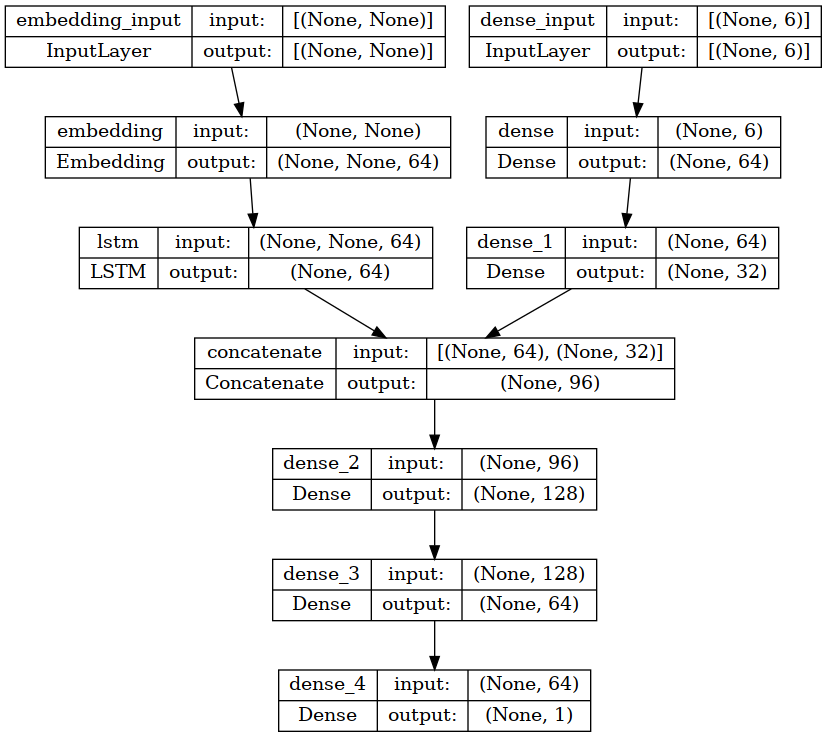

In [35]:
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True)

In [34]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_weights/best_model_weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min')

In [35]:
tf.random.set_seed(42)
history = model.fit([X_train_text_tf, X_train_num_tf], y_train_tf, epochs=50, verbose=1, validation_data=([X_test_text_tf, X_test_num_tf], y_test_tf), callbacks=[early_stopping, checkpoint])

Epoch 1/50
1000/1000 [==============================] - 13s 11ms/step - loss: 0.6632 - accuracy: 0.5803 - val_loss: 0.6541 - val_accuracy: 0.5911
Epoch 2/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6570 - accuracy: 0.5896 - val_loss: 0.6546 - val_accuracy: 0.5888
Epoch 3/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.4124 - accuracy: 0.7801 - val_loss: 0.2010 - val_accuracy: 0.9231
Epoch 4/50
1000/1000 [==============================] - 11s 11ms/step - loss: 0.1916 - accuracy: 0.9280 - val_loss: 0.1998 - val_accuracy: 0.9289
Epoch 5/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1741 - accuracy: 0.9376 - val_loss: 0.1784 - val_accuracy: 0.9320
Epoch 6/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1648 - accuracy: 0.9417 - val_loss: 0.1759 - val_accuracy: 0.9327
Epoch 7/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1549 - accuracy: 0.9459 - val_loss: 0.1805 - val_a

In [36]:
result = model.predict([X_test_text_tf, X_test_num_tf])
mean = result.mean()
std = result.std()
normolized_result = (result - mean) / std
normolized_result = 1 / (1+np.exp(-normolized_result))
print(classification_report(y_test_tf, (normolized_result.flatten() >= 0.5).astype('int') ))

250/250 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      4000
           1       0.96      0.92      0.94      4000

    accuracy                           0.94      8000
   macro avg       0.94      0.94      0.94      8000
weighted avg       0.94      0.94      0.94      8000



In [37]:
model.save("models/sentimental.h5")

/home/raychannudam/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [45]:
import pickle
pickle.dump({
    'config': vectorizer.get_config(),
    'weights': vectorizer.get_weights()
}, open("vectorizers/vectorizer.pkl", "wb"))

In [48]:
X_test_text_tf

<tf.Tensor: shape=(8000, 30), dtype=int64, numpy=
array([[   7,   19,    2, ...,    0,    0,    0],
       [3197,  639,   46, ...,    0,    0,    0],
       [2985,    7,   17, ...,    0,    0,    0],
       ...,
       [ 371,  210,    9, ...,    0,    0,    0],
       [  56,   13,    4, ...,    0,    0,    0],
       [  38,   26,   68, ...,    0,    0,    0]])>

In [50]:
X_test_num_tf.to_numpy()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        3.21887582],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        4.02535169],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        4.29045944],
       ...,
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        3.93182563],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        3.40119738],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        3.4657359 ]])